In [3]:
import os
import pandas as pd
import numpy as np 
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer    
from nltk.stem import WordNetLemmatizer
sns.set()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def getData(path):
    dataList = list()
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print(os.path.join(subdir, file))
            f = open(subdir+"/"+file, "r")
            dataList.append(f.read())
    return dataList
            
def avgWordCount(wordList):
    wordCount = 0
    for wordArray in wordList:
        wordCount += len(wordArray)
    wordAverage = wordCount/len(wordList)
    return wordAverage          


def preprocess(dataList, allPreprocessing = False):
    # https://textblob.readthedocs.io/en/dev/
    wordList = list()
    wordListStem = list()
    wordListLemmatized = list()
    
    # stemming / lemmatization
    # https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')

    stops = set(stopwords.words("english"))
    for text in dataList:
            # lowercase
            textLowercase = text.lower()
            # remove digits (not sure if we should do this, ad does is in the slides)
            textFiltered = re.sub(r'\b[0-9]+\b\s*', '', textLowercase)
            #print(text)
            # get textblob
            blob = TextBlob(textFiltered)
            # tokenize
            words = blob.words
            #print(words)
            if (allPreprocessing):
                # remove stopwords and stem
                wordsFiltered_stem = [stemmer.stem(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered_lemmatized = [wordnet_lemmatizer.lemmatize(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                #print(wordsFiltered)
                wordList.append(wordsFiltered)
                wordListStem.append(wordsFiltered_stem)
                wordListLemmatized.append(wordsFiltered_lemmatized)
            else:
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                wordList.append(wordsFiltered)
                
    if (allPreprocessing):            
        return (wordList, wordListStem, wordListLemmatized)
    else:
        return wordList

"""
https://www.mygreatlearning.com/blog/bag-of-words/#ed4
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
Calculate bag of words representation 
datasets: array with test data in first slot and training data in second slot
ngram: corresponding ngram: (1,1) for unigrams, (2,2) for bigrams
classDist = class distribution of the datasets. default assumes no prior changes to the data structure
return: each return consists of 2 dataframes: first dataframe is test data, second data is train data. 
        bag_of_words_data holds features with absolute count; bag_of_words_data_freq has word frequencies
"""
def bagOfWords(datasets, ngram, classDist = [np.repeat([0,1], 80),np.repeat([0,1], 320)]):
    # hyperparameters: max features, use_idf                                             
    vectorizer = CountVectorizer(ngram_range=ngram)#, max_features=750)
    bag_of_words_data_freq = list()
    bag_of_words_data = list()                                         
    tf_transformer = TfidfTransformer()#use_idf=True)
    for idx, dataset in enumerate(datasets):
        # reconcatenate data to sentence which is needed for countvectorizer
        concatTexts = list()
        for text in dataset:
            concatTexts.append(' '.join(text))
        # create bag of words representation
        if(idx == 0):
            countData = vectorizer.fit_transform(concatTexts)
        else:
            countData = vectorizer.transform(concatTexts)

        cv_df=pd.DataFrame(countData.toarray(),columns=vectorizer.get_feature_names())
        cv_df['class_target']=classDist[idx]
        bag_of_words_data.append(cv_df)

        freqData = tf_transformer.fit_transform(countData)
        cv_df_freq=pd.DataFrame(freqData.toarray(),columns=vectorizer.get_feature_names())
        cv_df_freq['class_target']=classDist[idx]
        bag_of_words_data_freq.append(cv_df_freq)
    return (bag_of_words_data, bag_of_words_data_freq, vectorizer)


"""
Calculate metrics for a model and plot the confusion matrix
actual: array with actual classes
pred: array with predicted classes
return: confusion matrix and a tuple with 3 values of accuracy, precision and recall
"""
def getModelInfo(actual, pred):
    df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    acc = (df_confusion[1][1] + df_confusion[0][0]) / (df_confusion[0]["All"] + df_confusion[1]["All"])
    prec = (df_confusion[1][1] / df_confusion[1]["All"])
    recall = (df_confusion[1][1] / df_confusion["All"][1])
    f1 =  2*((prec*recall)/(prec+recall))
    metrics = (acc, prec, recall, f1)
    plot_confusion_matrix(df_confusion)
    print("Metrics: \n   Accuracy: %f \n   Precision: %f \n   Recall: %f \n   F1: %f" % metrics)
    return df_confusion, metrics
"""
Plot the confusion matrix as a heatmap
df_confusion: confusion matrix from a model
return: nothing
"""
def plot_confusion_matrix(df_confusion):
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    return



In [5]:

from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [8]:
%%time
deceptive_test = getData(r"data\deceptive\test")
deceptive_train = getData(r"data\deceptive\train")
truthful_test = getData(r"data\truthful\test")
truthful_train = getData(r"data\truthful\train")
post_deceptive_test = preprocess(deceptive_test)
post_deceptive_train = preprocess(deceptive_train)
post_truthful_test = preprocess(truthful_test)
post_truthful_train = preprocess(truthful_train)
# bag of words dataset creation
# create array with test and train data
datasets = [post_deceptive_test + post_truthful_test, post_deceptive_train + post_truthful_train]
bag_of_words_data, bag_of_words_data_freq, vectorizer = bagOfWords(datasets = datasets, ngram = (1,1))
bag_of_words_test = bag_of_words_data[0]
bag_of_words_train = bag_of_words_data[1]
y_test = np.array(bag_of_words_test[['class_target']].values.ravel())
X_test = bag_of_words_test.drop('class_target', axis=1)
y_train = np.array(bag_of_words_train[['class_target']].values.ravel())
X_train = bag_of_words_train.drop('class_target', axis=1)
# Naive bayes with hyper parameter tuning




Wall time: 12min 14s


{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.4s finished


Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}


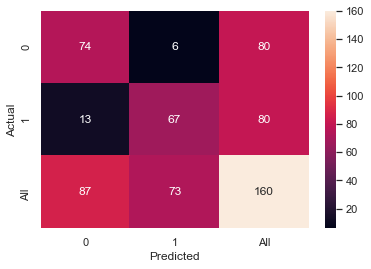

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
Wall time: 13.9 s


In [10]:
%%time
mnb_metrics_list = list()
#for y_test, X_test, y_train, X_train in zip(y_test_list, X_test_list, y_train_list, X_train_list):
alpha = np.linspace(start = 0.0, stop = 10.0, num = 30)
fit_prior = [True, False]

# Create the random grid
random_grid = {'alpha': alpha,
               'fit_prior': fit_prior}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
mnb = MultinomialNB()
# Random search of parameters, using 3 fold cross validation, 
# search across 60 different combinations, and use all available cores
mnb_random = RandomizedSearchCV(estimator = mnb, param_distributions = random_grid, n_iter = 60, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1')

# Fit the random search model
mnb_random.fit(X_train, y_train)

# print the best parameters
print("Best parameters")
print(mnb_random.best_params_)

# The best model
mnb_best_random = mnb_random.best_estimator_

# Predict Class
mnb_random_y_pred = mnb_best_random.predict(X_test)

# Accuracy 
mnb_cm, mnb_metrics = getModelInfo(y_test, mnb_random_y_pred)
mnb_metrics_list.append(mnb_metrics)

Standard configuration 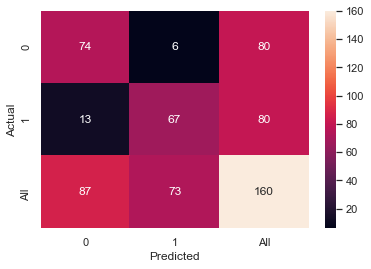
Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
   

Stemming cv=10 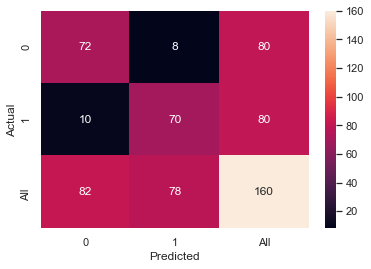
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
   
Lemmatization cv=10 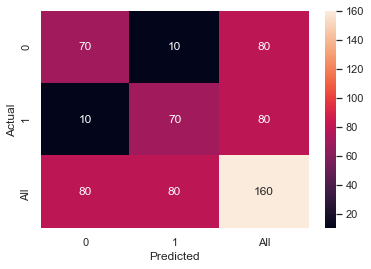
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000

In [2]:
#mnb_metrics_list

def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Word correction", "Correction + stemming", "Correction + lemmatization"])
    metrics_df.index.name = "Processing"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
#     flat_list = [item for sublist in metrics_list for item in sublist]
#     for i, v in enumerate(flat_list):
#         ax.text(i-.25, 
#                   v/flat_list[i]+100, 
#                   flat_list[i], 
#                   fontsize=18)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/preprocessing/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Preprocessing', value=["Word correction", "Correction + stemming", "Correction + lemmatization"]*4)
    metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)
    
#save_metrics(mnb_metrics_list)
#plotMetricsComparison(mnb_metrics_list, "pre_mnb")

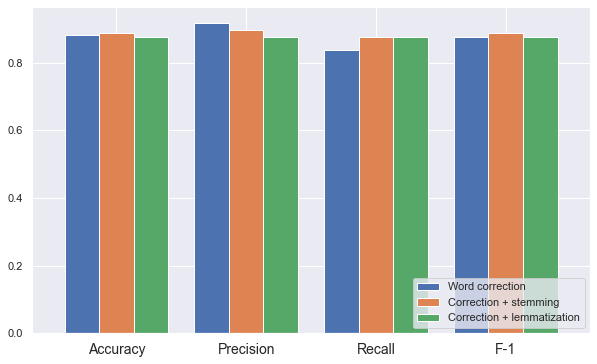

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [8]:
%%time
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_test",
    batch_size=batch_size
)
# Model constants.
max_features = 20000
embedding_dim = 100
sequence_length = 300

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)


def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

model = keras.Sequential()
model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
model.add(layers.Embedding(max_features, embedding_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
epochs = 150
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')


Found 640 files belonging to 2 classes.
Using 512 files for training.
Found 640 files belonging to 2 classes.
Using 128 files for validation.
Found 160 files belonging to 2 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x000001C42A002708>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [7]:
%%time
# Fit the model using the train and test datasets.
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    callbacks=[es],
                    epochs=epochs)

# data = [(x, y) for x, y in test_ds] 
# y_test = np.concatenate([y for (x, y) in data])
# x_test = np.concatenate([x for (x, y) in data])
# y_pred_cnn = np.concatenate(model.predict_classes(x_test))
# cnn_cm, cnn_metrics = getModelInfo(y_test, y_pred_cnn)

Epoch 1/150
16/16 [==============================] - 1s 68ms/step - loss: 0.6965 - accuracy: 0.4785 - val_loss: 0.6928 - val_accuracy: 0.5156
Epoch 2/150
16/16 [==============================] - 1s 60ms/step - loss: 0.6889 - accuracy: 0.5449 - val_loss: 0.6935 - val_accuracy: 0.4453
Epoch 3/150
16/16 [==============================] - 1s 61ms/step - loss: 0.6851 - accuracy: 0.5684 - val_loss: 0.6894 - val_accuracy: 0.5156
Epoch 4/150
16/16 [==============================] - 1s 61ms/step - loss: 0.6757 - accuracy: 0.5625 - val_loss: 0.6838 - val_accuracy: 0.5859
Epoch 5/150
16/16 [==============================] - 1s 62ms/step - loss: 0.6608 - accuracy: 0.6797 - val_loss: 0.6720 - val_accuracy: 0.5938
Epoch 6/150
16/16 [==============================] - 1s 62ms/step - loss: 0.6035 - accuracy: 0.8301 - val_loss: 0.6231 - val_accuracy: 0.7500
Epoch 7/150
16/16 [==============================] - 1s 60ms/step - loss: 0.4669 - accuracy: 0.9082 - val_loss: 0.5207 - val_accuracy: 0.8203
Epoch 

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()



5/5 [==============================] - 0s 7ms/step - loss: 0.3689 - accuracy: 0.8687
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
___________________________________

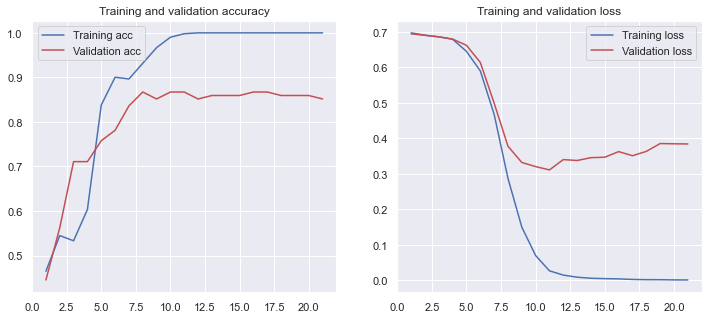

In [116]:
model.evaluate(test_ds)
plot_history(history)
model.summary()

In [10]:
import sys
import pathlib
from tensorflow.keras.optimizers import Adam

In [11]:
%%time
os.chdir(r"C:\Users\quach\OneDrive\Desktop\Code\Python")
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


data_path = r"C:\Users\quach\OneDrive\Desktop\Code\Python\data\embedded"
data_dir = pathlib.Path(data_path)
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    #print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples.append(content)
        labels.append(class_index)
    class_index += 1



data_path_test = r"C:\Users\quach\OneDrive\Desktop\Code\Python\data\embedded_test"
data_dir_test = pathlib.Path(data_path_test)
samples_test = []
labels_test = []
class_names_test = []
class_index = 0

for dirname in sorted(os.listdir(data_dir_test)):
    class_names_test.append(dirname)
    dirpath = data_dir_test / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_test.append(content)
        labels_test.append(class_index)
    class_index += 1


# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:5]
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        


embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)





int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Dropout(0.5)(embedded_sequences)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
model = keras.Model(int_sequences_input, predictions)



x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in samples_test])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(labels_test)
model.compile(
    loss="binary_crossentropy", optimizer=Adam(lr=0.001), 
    metrics=["accuracy"]
)

# es = keras.callbacks.EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=20,
#                               verbose=0, mode='auto')


Processing deceptive, 80 files found
Processing truthful, 80 files found
Wall time: 12.8 s


In [12]:
%%time
history = model.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=84, 
                    #callbacks = [es], 
                    validation_data=(x_val, y_val))


# y_pred_cnn_embed = np.concatenate(model.predict(x_test) > 0.5).astype("int32")
# cnn_embed_cm, cnn_embed_metrics = getModelInfo(np.asarray(y_test), y_pred_cnn_embed)

Epoch 1/84
4/4 [==============================] - 0s 75ms/step - loss: 1.1002 - accuracy: 0.5137 - val_loss: 0.8056 - val_accuracy: 0.5625
Epoch 2/84
4/4 [==============================] - 0s 57ms/step - loss: 0.9011 - accuracy: 0.4707 - val_loss: 0.7676 - val_accuracy: 0.4375
Epoch 3/84
4/4 [==============================] - 0s 57ms/step - loss: 0.8382 - accuracy: 0.5078 - val_loss: 0.6806 - val_accuracy: 0.5938
Epoch 4/84
4/4 [==============================] - 0s 55ms/step - loss: 0.7443 - accuracy: 0.4902 - val_loss: 0.6777 - val_accuracy: 0.5625
Epoch 5/84
4/4 [==============================] - 0s 53ms/step - loss: 0.7196 - accuracy: 0.5176 - val_loss: 0.6879 - val_accuracy: 0.4766
Epoch 6/84
4/4 [==============================] - 0s 54ms/step - loss: 0.6935 - accuracy: 0.5488 - val_loss: 0.7059 - val_accuracy: 0.4453
Epoch 7/84
4/4 [==============================] - 0s 49ms/step - loss: 0.6773 - accuracy: 0.5918 - val_loss: 0.6818 - val_accuracy: 0.5391
Epoch 8/84
4/4 [===========

4/4 [==============================] - 0s 52ms/step - loss: 0.0969 - accuracy: 0.9746 - val_loss: 0.4606 - val_accuracy: 0.8359
Epoch 60/84
4/4 [==============================] - 0s 48ms/step - loss: 0.0914 - accuracy: 0.9805 - val_loss: 0.4539 - val_accuracy: 0.8359
Epoch 61/84
4/4 [==============================] - 0s 50ms/step - loss: 0.0949 - accuracy: 0.9824 - val_loss: 0.4840 - val_accuracy: 0.8203
Epoch 62/84
4/4 [==============================] - 0s 53ms/step - loss: 0.1083 - accuracy: 0.9668 - val_loss: 0.4637 - val_accuracy: 0.8359
Epoch 63/84
4/4 [==============================] - 0s 54ms/step - loss: 0.0930 - accuracy: 0.9727 - val_loss: 0.4967 - val_accuracy: 0.8125
Epoch 64/84
4/4 [==============================] - 0s 55ms/step - loss: 0.0856 - accuracy: 0.9785 - val_loss: 0.4207 - val_accuracy: 0.8438
Epoch 65/84
4/4 [==============================] - 0s 53ms/step - loss: 0.0825 - accuracy: 0.9785 - val_loss: 0.4746 - val_accuracy: 0.8281
Epoch 66/84
4/4 [===============

5/5 [==============================] - 0s 7ms/step - loss: 0.5731 - accuracy: 0.8062
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 100)         464900    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         89728     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
__________________________________

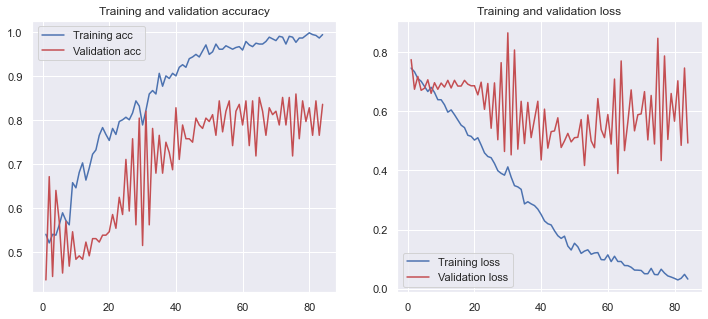

In [19]:
model.evaluate(test_ds)
plot_history(history)
model.summary()

In [129]:
mnb_metrics_list.append(cnn_metrics)
mnb_metrics_list.append(cnn_embed_metrics)
mnb_metrics_list

[(0.88125, 0.9178082191780822, 0.8375, 0.8758169934640524),
 (0.86875, 0.8734177215189873, 0.8625, 0.8679245283018868),
 (0.75625, 0.9183673469387755, 0.5625, 0.6976744186046512)]

Algorithm  Multinomial Naive Bayes       CNN  CNN + Glove Embedding
Accuracy                  0.881250  0.868750               0.756250
Precision                 0.917808  0.873418               0.918367
Recall                    0.837500  0.862500               0.562500
F-1                       0.875817  0.867925               0.697674


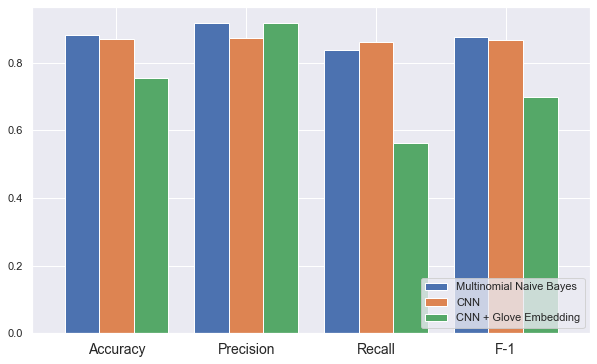

                         Accuracy  Precision  Recall       F-1
Algorithm                                                     
Multinomial Naive Bayes   0.88125   0.917808  0.8375  0.875817
CNN                       0.86875   0.873418  0.8625  0.867925
CNN + Glove Embedding     0.75625   0.918367  0.5625  0.697674


In [135]:
def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    metrics_df.index.name = "Algorithm"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
#     flat_list = [item for sublist in metrics_list for item in sublist]
#     for i, v in enumerate(flat_list):
#         ax.text(i-.25, 
#                   v/flat_list[i]+100, 
#                   flat_list[i], 
#                   fontsize=18)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Algorithm', value=["Multinomial Naive Bayes", "CNN", "CNN + Glove Embedding"])
    #metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)
    
plotMetricsComparison(mnb_metrics_list)
save_metrics(mnb_metrics_list)